# Exploring linear regions with tropical geometry

## Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import numpy.core.multiarray
from scipy.optimize import linprog
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, KFold

from tqdm.notebook import tqdm
import os

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D
import scienceplots
from matplotlib.legend_handler import HandlerBase
from matplotlib.patches import Rectangle

from scipy.spatial import HalfspaceIntersection, ConvexHull

import networkx as nx
import itertools
import matplotlib.colors as mcolors
import warnings 

plt.style.use("science")

In [2]:
# # Prevent `ImportError: numpy.core.multiarray failed to import` for scipy.optimize.linprog
# !pip install numpy==1.26.4

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


## Neural network to approximate 3D function

### Define and plot 3D function

Functions $\phi_1$ through $\phi_4$ in the paper are defined here. Use a dict to also store TeX tiles and filenames.

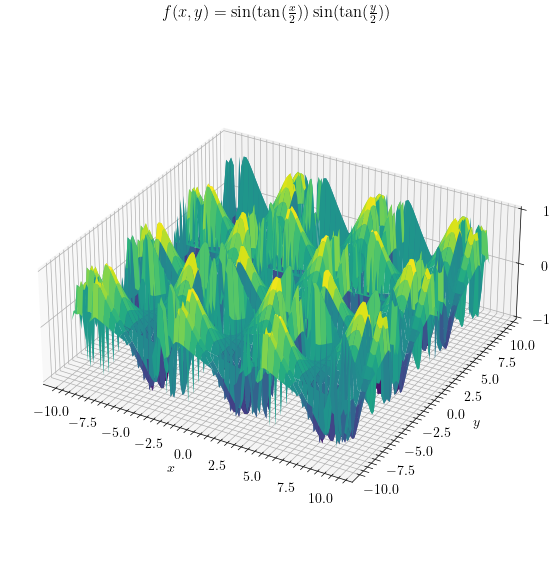

In [3]:
functions = [
    {"title": r"$f(x,y)=\sin(\log|x|+\log|y|)$",
    "filename": r"func0 sin(logx+logy)",
    "func": lambda x, y: np.sin((np.log(np.abs(x)) + np.log(np.abs(y))))},

    {"title": r"$f(x,y) = \frac{\sin(\sqrt{x^2 + y2})}{\sqrt{x2 + y^2}}$",
    "filename": r"func1 sin(sqrt(x2+y2)) div sqrt(x2+y2)",
    "func": lambda x, y: np.sin(np.sqrt(x**2+y**2))/np.sqrt(x**2+y**2)},
    
    {"title": r"$f(x,y) = \sin(\cos(\frac{x}{2}))\sin(\cos(\frac{y}{2}))$",
    "filename": r"func2 sin(cosx)sin(cosy)",
    "func": lambda x, y: np.sin(np.cos(x/2))*np.sin(np.cos(y/2))},
    
    {"title": r"$f(x,y) = \sin(\tan(\frac{x}{2}))\sin(\tan(\frac{y}{2}))$",
    "filename": r"func3 sin(tanx)sin(tany)",
    "func": lambda x, y: np.sin(np.tan(x/2))*np.sin(np.tan(y/2))},
]

def plot_function(function):
    """
    Create basic 3D plot of 
    """
    x = np.linspace(-10, 10, 100)
    y = np.linspace(-10, 10, 100)
    x, y = np.meshgrid(x, y)
    z = function["func"](x, y)

    fig = plt.figure(figsize=(20, 6))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(x, y, z, cmap="viridis")
    
    ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1.0, 1.0, 0.5, 1]))
    
    ax.set_zticks([-1, 0, 1])
    
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.set_zlabel("$z$")
    ax.set_title(function["title"], pad=10)
    
    fig.subplots_adjust(top=0.85, bottom=0.15, left=0.05, right=0.95)
    plt.tight_layout()
    
    plt.show()

plot_function(functions[3])

### Define and train neural network

`Approximator` is our basic neural network class

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch [500/5000], Loss: 0.0263
Epoch [1000/5000], Loss: 0.0188
Epoch [1500/5000], Loss: 0.0110
Epoch [2000/5000], Loss: 0.0091
Epoch [2500/5000], Loss: 0.0084
Epoch [3000/5000], Loss: 0.0081
Epoch [3500/5000], Loss: 0.0079
Epoch [4000/5000], Loss: 0.0078
Epoch [4500/5000], Loss: 0.0076
Epoch [5000/5000], Loss: 0.0075


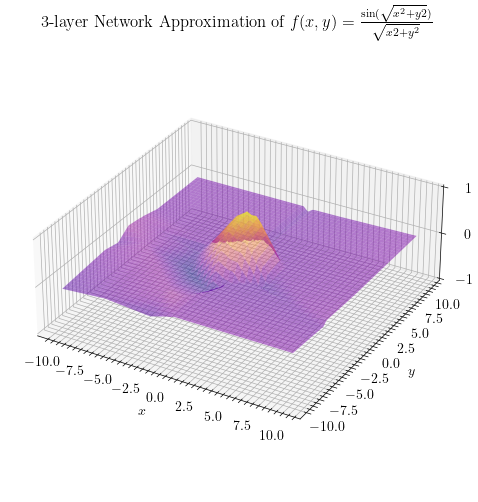

In [4]:
class Approximator(nn.Module):
    """
    Basic neural network to approximate a 3D function
    """
    def __init__(self, input_size, hidden_size, output_size, num_layers, skip_connections=None):
        """
        If specified, `skip_connections` should be a list (or other iterable) where each entry is a tuple/iterable containing 2 ints.
        Entering e.g. `[(0,3), (4,6)]` 
        means that the output of hidden layer 0 (first hidden layer) feeds into the input of hidden layer 3, and output of 4 feeds into input of 6.
        """
        super(Approximator, self).__init__()
        layers = [nn.Linear(input_size, hidden_size), nn.ReLU()] 
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_size, output_size))
        self.model = nn.Sequential(*layers)

        self.num_layers = num_layers
        self.hidden_size = hidden_size

        self.skip_connections = skip_connections
        if skip_connections is None:
            self.forward = self._forward_noskip
        else:
            self.forward = self._forward_skip

    def _forward_noskip(self, x):
        """
        Simple `forward` method to be used when no skip connections are provided.
        """
        return self.model(x)

    def _forward_skip(self, x):
        """
        `forward` method supporting skip connections.
        Would be more readable if re-written so that Linear and ReLU layers are paired, but the rest of the code was written before this
        """
        previous_layers = []
        out = x
        layer_counter = 0
        for layer in self.model:
            if isinstance(layer, nn.Linear):
                for (skip_from, skip_to) in self.skip_connections:
                    if layer_counter == skip_to:
                        out = out + previous_layers[skip_from]
                out = layer(out)
                layer_counter += 1
            elif isinstance(layer, nn.ReLU): # After ReLU activation, append to layer list
                out = layer(out)
                previous_layers.append(out) # Post-activation
        return out

def train_model(model, function, num_epochs=1000, learning_rate=1e-3, plot=False):
    """
    Basic training loop with Adam optimizer. If plot=True, displays a plot of fitted function.
    """

    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Generate training data and convert to PyTorch tensors
    x = np.linspace(-10, 10, 100)
    y = np.linspace(-10, 10, 100)
    x, y = np.meshgrid(x, y)
    z = function["func"](x, y)
    inputs = torch.tensor(np.vstack((x.flatten(), y.flatten())).T, dtype=torch.float32).to(device)
    targets = torch.tensor(z.flatten(), dtype=torch.float32).view(-1, 1).to(device)
    
    # Main training loop
    for epoch in tqdm(range(num_epochs)):
        model.train()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 500 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

    if plot:
        model.eval()
        with torch.no_grad():
            # Not really an actual test set, just used for plotting
            test_inputs = torch.tensor(np.vstack((x.flatten(), y.flatten())).T, dtype=torch.float32).to(device)
            test_outputs = model(test_inputs)
            test_outputs = test_outputs.cpu().numpy().reshape(x.shape)
        fig = plt.figure(figsize=(20, 6))
        ax = fig.add_subplot(111, projection="3d")
        # ax.plot_surface(x, y, z, cmap="viridis", alpha=0.5, label="Original")
        ax.plot_surface(x, y, test_outputs, cmap="plasma", alpha=0.5, label="Predicted")
        
        ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1.0, 1.0, 0.5, 1]))
        ax.set_zticks([-1, 0, 1])
        ax.set_title(f"{num_layers}-layer Network Approximation of {function['title']}")
        ax.set_xlabel("$x$")
        ax.set_ylabel("$y$")
        ax.set_zlabel("$z$")
        
        plt.show()

# Model initialization
input_size = 2
hidden_size = 5
output_size = 1
num_layers = 3
skip_connections = [(0,2)]
model = Approximator(input_size, hidden_size, output_size, num_layers, skip_connections).to(device)

train_model(model, functions[1], num_epochs=5000, plot=True)

### Find hyperplanes defined by ReLU activations in network

In [5]:
def get_dimensions(model):
    """
    Helper function for `get_truth_assignments`.
    Returns list of integers. Each entry corresponds to the size of each layer in `model` that has ReLU activation.
    """
    dims_list = []
    layers = list(model.children())
    if isinstance(layers[0], nn.Sequential): # When all layers are contained within a single nn.Sequential, we first need to unpack it
        layers = layers[0]
    for i in range(len(layers)-1):
        # Find layers that have ReLU activation
        if isinstance(layers[i], nn.Linear) and isinstance(layers[i + 1], nn.ReLU):
            dims_list.append(layers[i].weight.size(0))
    return dims_list

def get_feasible_point(hyperplanes, tol=1e-12):
    """
    Finds feasible region for linear program A_ub * x <= b_ub, 
    where A_ub is constructed from vector parts of hyperplanes, and b_ub is constructed from scalar parts
    """
    A_ub = np.array([plane[0] for plane in hyperplanes])
    b_ub = np.array([plane[1] for plane in hyperplanes])
    b_ub = np.array(b_ub) - tol # Enforce strict inequality (to prevent regions from having 0 area)
    
    c = np.zeros(A_ub.shape[1]) # Objective function (minimize zeros, which means just checking feasibility)
    
    result = linprog(c, A_ub=A_ub, b_ub=b_ub, method="highs", bounds=(None,None))
    return result

def get_truth_assignments(model):
    """
    Returns list where the i-th entry is a list of all possible truth assignments of 0/1 to neurons in the i-th layer
    """
    dims_list = get_dimensions(model)
    num_neurons = np.sum(dims_list)
    num_assignments = 2**num_neurons

    assignments = []
    for dim in dims_list:
        ta = [] # Truth assignment
        for i in range(2**dim):
            bin_i = str(bin(i)[2:]).zfill(dim) # Binary representation of i (padded with zeros)
            bin_i = np.asarray(list(bin_i), dtype=int)
            ta.append(bin_i)
        assignments.append(ta)
    return assignments

def matrix_to_nonnegative(A):
    """
    Helper function for get_linear_region.
    Given matrix `A`, returns two matrices `A_pos` and `A_neg` s.t. A=A_pos-A_neg and all entries in A_pos and A_neg are non-negative.
    """
    A_pos = A.copy()
    A_pos[A<0] = 0
    
    A_neg = -1 * A.copy()
    A_neg[A>0] = 0
    return A_pos, A_neg

def get_linear_region(model, ta):
    """
    Given a truth assignment `ta`, which maps each neuron to 0 or 1, find the set of hyperplanes that defines the linear region.
    A neuron mapping to 0 means that we choose the negative half of the ReLU activation, and 1 means positive half.
    """
    # Initial bounding box: (-10,10) x (-10,10)
    hyperplanes = [(np.array([1,0]),10),
                   (np.array([-1,0]),10),
                   (np.array([0,1]),10),
                   (np.array([0,-1]),10),]

    # Initialize F^(0), H^(0), G^(0), and their respective vectors
    F = np.eye(model.model[0].in_features)
    H, G = matrix_to_nonnegative(F) # H^(0) is identity, G^(0) is zero matrix.
    F_vec = np.zeros(F.shape[0])
    G_vec = np.zeros(F.shape[0])
    H_vec = np.zeros(F.shape[0])
    previous = [] # Storage of values of G and H to use in skip connections (H not needed)
    layer_index = 0
    for i in range(len(model.model)-1):
        layer = model.model[i]
        if isinstance(layer, nn.Linear) and isinstance(model.model[i+1], nn.ReLU): # If layer has ReLU activation
            A = layer.weight.detach().numpy()
            b = layer.bias.detach().numpy()
            A_pos, A_neg = matrix_to_nonnegative(A)

            # Recurrence relations
            G_next = A_pos @ G + A_neg @ F
            H_next = A_pos @ F + A_neg @ G
            G_vec_next = A_pos @ G_vec + A_neg @ F_vec
            H_vec_next = A_pos @ F_vec + A_neg @ G_vec + b

            # Account for skip connections
            # This part of the recurrence relation only affects G and H, but must be before activation has been applied (i.e. F_next not yet calculated)
            if model.skip_connections is not None:
                skips_in = [j for (j,k) in model.skip_connections if k==layer_index]
                for j in skips_in:
                    F_prev, G_prev, F_vec_prev, G_vec_prev, = previous[j]
                    G_next += A_neg @ (F_prev - G_prev)
                    H_next += A_pos @ (F_prev - G_prev)
                    G_vec_next += A_neg @ (F_vec_prev - G_vec_prev)
                    H_vec_next += A_pos @ (F_vec_prev - G_vec_prev)

            # Take the truth assignment as one column. Repeat this col horizontally so that every row contains entirely 0 or entirely 1.
            repeated_ta = np.repeat(ta[layer_index], F.shape[1]).reshape(len(ta[layer_index]), F.shape[1])
            
            # If we were just computing the output normally, this would just be `F_next = max(H_next, G_next)`
            # For cols where we assign 0 to a neuron, we choose left side of max() function (H_next), and choose G_next otherwise.
            F_next = np.where(repeated_ta == 1, H_next, G_next)
            F_vec_next = np.where(ta[layer_index] == 1, H_vec_next, G_vec_next)

            # A hyperplane is introduced at each row of the solution of H^(l+1)(x) = G^(l+1)(x).
            # For each row, use the truth assignment to pick which half of the hyperplane we want
            hyp_A = H_next - G_next
            hyp_b = G_vec_next - H_vec_next
            for j in range(hyp_A.shape[0]):
                if ta[layer_index][j] == 0: 
                    # Truth assignment chooses the half of hyperplane given by G, so we have H < G. 
                    # Resulting linear program is A_ub*x <= b_ub, where A_ub=(H-G) and b_ub=(G_vec-H_vec)
                    hyperplanes.append((hyp_A[j], hyp_b[j]))
                else: 
                    # Resulting linear program has A_ub=(G-H) and b_ub=(H_vec-G_vec), so multiply by -1
                    hyperplanes.append((-hyp_A[j], -hyp_b[j]))

            # Before next iteration, update values
            F = F_next
            G = G_next
            H = H_next
            F_vec = F_vec_next
            G_vec = G_vec_next
            H_vec = H_vec_next

            if model.skip_connections is not None:
                previous.append((F,G,F_vec,G_vec)) # Store for future skip connections
            layer_index += 1

            if not get_feasible_point(hyperplanes).success:
                # If region is infeasible now, it will still be infeasible with more iterations
                # Return the index of the layer where this truth assignment became infeasible so dfs can rule it out
                return layer_index
                
    return hyperplanes

def dfs(model, truth_assignments, current_assignments, depth, results, pbar):
    """
    Recursive backend of `get_all_linear_regions`.
    Performs recursive depth-first search of all truth assignments.
        `truth_assignments` - assignments generated by `get_truth_assignments`
        `depth` - current depth
        `results` - passed by reference. Results are not returned
        `pbar` - tqdm progress bar
    """
    if depth == len(truth_assignments):
        result = get_linear_region(model, current_assignments)
        if isinstance(result, int): # Infeasible region - returns index of failure
            return result # fail_index
        else:
            if pbar is not None:
                pbar.update(1)
            results.append(result)
            return

    for layer_assignment in truth_assignments[depth]:
        fail_index = dfs(model, truth_assignments, current_assignments+[layer_assignment], depth + 1, results, pbar)
        if fail_index is not None:
            if depth >= fail_index:
                return fail_index
            else:
                if pbar is not None:
                    num_skipped = np.prod([len(l) for l in truth_assignments[depth+1:]]) # product of num neurons in deeper layers
                    pbar.update(int(num_skipped))

def get_all_linear_regions(model, use_tqdm=True):
    """
    Performs depth-first search over all possible truth assignments 0/1 to each neuron.
    Whenever a region is found to be infeasible, dfs abandons the branch corresponding to it
    """
    model = model.to("cpu") # Prevent repeated copying back and forth
    truth_assignments = get_truth_assignments(model)
    num_neurons = np.sum(get_dimensions(model))
    total_combinations = 2 ** np.sum(get_dimensions(model))
    results = []
    if use_tqdm:
        with tqdm(total=total_combinations, desc="Finding linear regions", colour="orange", mininterval=0.5, smoothing=0) as pbar:
            dfs(model, truth_assignments, [], 0, results, pbar) # `results` is filled after being passed by reference
    else:
        dfs(model, truth_assignments, [], 0, results, None)
    model = model.to(device)
    return results
    
linear_regions = get_all_linear_regions(model)

Finding linear regions:   0%|          | 0/32768 [00:00<?, ?it/s]

### Plot linear regions

Number of regions: 91


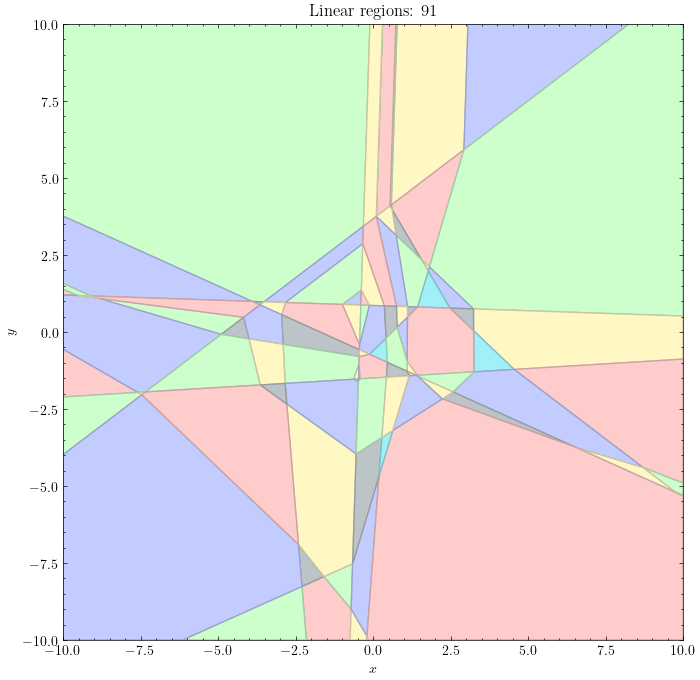

In [6]:
def get_region_intersection(hyperplanes):
    """
    Given a set of half-planes, construct scipy.spatial.HalfspaceIntersection object representing their intersections
    """
    # Use HalfspaceIntersection to find vertices of linear region
    feasible_point = get_feasible_point(hyperplanes)
    if not feasible_point.success:
        raise ValueError("No feasible point found")
    feasible_point = feasible_point.x
    
    # Convert (a, b) pairs to the format required by HalfspaceIntersection.
    # Currently, pairs are in form Ax < b. HalfspaceIntersection expects Ax+b<0
    halfspaces = []
    for plane in hyperplanes:
        a, b = plane[:2]
        halfspaces.append(np.append(a, -b))  # ax + b < 0 -> [a, -b]

    hs = HalfspaceIntersection(np.array(halfspaces), feasible_point)
    
    return hs

def sort_vertices(vertices):
    """
    Sort clockwise so that resulting region is plotted as convex hull of given vertices.
    """
    centroid = np.mean(vertices, axis=0)
    sorted_vertices = sorted(vertices, key=lambda v: np.arctan2(v[1] - centroid[1], v[0] - centroid[0]))
    return sorted_vertices

def darken_color(color, amount=0.5):
    """
    Helper function for `plot_regions`. Darken a given color by a specified amount.
    """
    try:
        c = mcolors.cnames[color]
    except:
        c = color
    c = mcolors.ColorConverter.to_rgb(c)
    c = [max(0, min(1, x * amount)) for x in c]
    return c
    
def plot_regions(regions, save_dir=None, save_dir2=None, show=True):
    """
    Using the linear regions found by `get_all_linear_regions`, color and plot regions with matplotlib.
    If save_dir is specified, also saves resulting figure in given directory. Can also specify second dir, save_dir2, for two formats.
    """
    fig, ax = plt.subplots(figsize=(8,8))
    region_vertices = []
    colors = ["#ffcccc", "#c2ccff", "#ccffcc", "#fff8c5", "#bcc4c8", "#9ff0f9", "#aceff7"] # red, blue, green, yellow, gray, teal, purple
    edge_colors = [darken_color(c, 0.8) for c in colors]
    for hyperplanes in regions:
        hs = get_region_intersection(hyperplanes)
        vertices = hs.intersections
        vertices = sort_vertices(vertices)
        region_vertices.append(vertices)
    
    # Graph coloring
    G = nx.Graph()
    for i, v1 in enumerate(region_vertices):
        for j, v2 in enumerate(region_vertices):
            if i < j:
                if any(np.allclose(a, b) for a, b in itertools.product(v1, v2)): # Adjacent regions share vertices
                    G.add_edge(i, j)
    coloring = nx.coloring.greedy_color(G, strategy="largest_first")
    if max(coloring.values())+1 > len(colors):
        warnings.warn(f"Graph coloring uses {max(coloring.values())+1} colors, but only {len(colors)} colors are defined. Some neighboring regions have same color.")
    for i, v in enumerate(region_vertices):
        color = colors[coloring[i] % len(colors)]
        edge_color = edge_colors[coloring[i] % len(colors)]
        ax.fill(*zip(*v), color=color, edgecolor=edge_color)
    
    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.set_title(f"Linear regions: {len(regions)}")

    if save_dir is not None:
        fig.savefig(save_dir)
    if save_dir2 is not None:
        fig.savefig(save_dir2)
    if show:
        plt.show()
    
print(f"Number of regions: {len(linear_regions)}")
plot_regions(linear_regions)#, save_dir="images/test.svg")

## Experiments

### Using the functions we've defined so far, plot graphs of linear regions for various parameter configurations

In [9]:
def train_and_track(model, function, num_epochs=5000, learning_rate=1e-3, epochs_per_eval=500, epochs_per_plot=None, print_progress=True):
    """
    Train a neural network while tracking the number of linear regions.
    """
    if epochs_per_plot is None:
        epochs_per_plot = epochs_per_eval

    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Generate training data and convert to PyTorch tensors
    x = np.linspace(-10, 10, 100)
    y = np.linspace(-10, 10, 100)
    x, y = np.meshgrid(x, y)
    z = function["func"](x, y)
    inputs = torch.tensor(np.vstack((x.flatten(), y.flatten())).T, dtype=torch.float32).to(device)
    targets = torch.tensor(z.flatten(), dtype=torch.float32).view(-1, 1).to(device)

    # For testing data, evaluate at unseen coordinates. These coordinates are the midpoints between training coords
    x_test = np.linspace(-10, 10, 100) + 0.1
    y_test = np.linspace(-10, 10, 100) + 0.1
    x_test, y_test = np.meshgrid(x_test, y_test)
    z_test = function["func"](x_test, y_test)
    inputs_test = torch.tensor(np.vstack((x_test.flatten(), y_test.flatten())).T, dtype=torch.float32, requires_grad=False).to(device)
    targets_test = torch.tensor(z_test.flatten(), dtype=torch.float32, requires_grad=False).view(-1, 1).to(device)

    linear_region_hist = []
    loss_hist = []
    loss_hist_test = []
    
    # Main training loop
    for epoch in tqdm(range(num_epochs),mininterval=0.5, leave=False, desc="Epochs"):
        model.train()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % epochs_per_eval == 0:
            model.eval()
            
            linear_regions = get_all_linear_regions(model, use_tqdm=print_progress)
            linear_region_hist.append(len(linear_regions))
            
            outputs_test = model(inputs_test)
            loss_test = criterion(outputs_test, targets_test)
            loss_hist.append(loss.item())
            loss_hist_test.append(loss_test.item())
            if print_progress:
                print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

        if (epoch + 1) % epochs_per_plot == 0:
            prefix = "noskip" if model.skip_connections is None else "skip"
            save_folder = f"images/{function['filename']}/{prefix}_{model.num_layers}layers_{model.hidden_size}neurons/"
            save_filename = f"epoch{epoch+1}.svg"
            save_filename2 = f"epoch{epoch+1}.jpg" # Jpg version for easy browsing later
            if not os.path.exists(save_folder):
                os.makedirs(save_folder)
            try:
                plot_regions(linear_regions, save_dir=f"{save_folder}{save_filename}", save_dir2=f"{save_folder}{save_filename2}", show=False)
            except:
                print(f"Qhull failed ({len(linear_regions)} regions, {save_folder}{save_filename}") # Skip the occassional QhullError - these are rare
            plt.close(fig="all")
        
    return linear_region_hist, loss_hist, loss_hist_test

# parameter_combinations = [              (2,4), (2,5), (2,6), (2,7), (2,8), (2,9), (2,12),
#                                  (3,3), (3,4), (3,5), (3,6), (3,7),
#                           (4,2), (4,3), (4,4), (4,5), (4,6),
#                           (5,2), (5,3), (5,4), (5,5)]

parameter_combinations = [(6,5)]
skip_connections = [(0,2), (1,3), (3,5), (2,6)]

for i in tqdm(range(len(functions)), colour="gray", desc="Functions"):
    print(f"Current function: {functions[i]['filename']}")
    function_folder = f"images/{functions[i]['filename']}/"
    function_filename = f"{functions[i]['filename']}.svg"
    function_filename2 = f"{functions[i]['filename']}.jpg"

    # Create image of function
    if not os.path.exists(function_folder):
        os.makedirs(function_folder)
    if not os.path.isfile(f"{function_filename}{function_filename}"):
        x = np.linspace(-10, 10, 100)
        y = np.linspace(-10, 10, 100)
        x, y = np.meshgrid(x, y)
        z = functions[i]["func"](x, y)
        
        fig, ax = plt.subplots(figsize=(8,8))
        cax = ax.imshow(z, extent=[-10, 10, -10, 10], origin="lower", cmap="Spectral")
        fig.colorbar(cax, ax=ax, shrink=0.75)
        ax.set_xlabel("$x$")
        ax.set_ylabel("$y$")
        ax.set_title(functions[i]["title"])
        fig.savefig(f"{function_folder}{function_filename}")
        fig.savefig(f"{function_folder}{function_filename2}") # Jpg version for easy browsing later

    # Train and track neural network, and save images
    for num_layers, hidden_size in tqdm(parameter_combinations, colour="purple", leave=False, desc="Parameter combinations"):
        
        # Model initialization
        input_size = 2
        output_size = 1
        model = Approximator(input_size, hidden_size, output_size, num_layers, skip_connections).to(device)

        # Train + track
        # epochs_per_eval = 250 if num_layers * hidden_size <= 18 else 1250
        epochs_per_eval = 1250 if num_layers * hidden_size <= 18 else 5000
        linear_region_hist, loss_hist = train_and_track(model, functions[i], num_epochs=5_000, epochs_per_eval=epochs_per_eval, print_progress=True)

Functions:   0%|          | 0/4 [00:00<?, ?it/s]

Current function: func0 sin(logx+logy)


Parameter combinations:   0%|          | 0/1 [00:00<?, ?it/s]

Epochs:   0%|          | 0/5000 [00:00<?, ?it/s]

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x000001974A1A39C0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

### Compare number of linear regions over time between networks with and without skip connections

Functions:   0%|          | 0/4 [00:00<?, ?it/s]

Epochs:   0%|          | 0/5000 [00:00<?, ?it/s]

Epochs:   0%|          | 0/5000 [00:00<?, ?it/s]

Epochs:   0%|          | 0/5000 [00:00<?, ?it/s]

Epochs:   0%|          | 0/5000 [00:00<?, ?it/s]

Epochs:   0%|          | 0/5000 [00:00<?, ?it/s]

Epochs:   0%|          | 0/5000 [00:00<?, ?it/s]

Epochs:   0%|          | 0/5000 [00:00<?, ?it/s]

Epochs:   0%|          | 0/5000 [00:00<?, ?it/s]

Functions:   0%|          | 0/4 [00:00<?, ?it/s]

Epochs:   0%|          | 0/5000 [00:00<?, ?it/s]

Epochs:   0%|          | 0/5000 [00:00<?, ?it/s]

Epochs:   0%|          | 0/5000 [00:00<?, ?it/s]

Epochs:   0%|          | 0/5000 [00:00<?, ?it/s]

Epochs:   0%|          | 0/5000 [00:00<?, ?it/s]

Epochs:   0%|          | 0/5000 [00:00<?, ?it/s]

Epochs:   0%|          | 0/5000 [00:00<?, ?it/s]

Epochs:   0%|          | 0/5000 [00:00<?, ?it/s]

Functions:   0%|          | 0/4 [00:00<?, ?it/s]

Epochs:   0%|          | 0/5000 [00:00<?, ?it/s]

Epochs:   0%|          | 0/5000 [00:00<?, ?it/s]

Epochs:   0%|          | 0/5000 [00:00<?, ?it/s]

Qhull failed (30 regions, images/func1 sin(sqrt(x2+y2)) div sqrt(x2+y2)/noskip_5layers_4neurons/epoch3000.svg


Epochs:   0%|          | 0/5000 [00:00<?, ?it/s]

Epochs:   0%|          | 0/5000 [00:00<?, ?it/s]

Epochs:   0%|          | 0/5000 [00:00<?, ?it/s]

Epochs:   0%|          | 0/5000 [00:00<?, ?it/s]

Epochs:   0%|          | 0/5000 [00:00<?, ?it/s]

Functions:   0%|          | 0/4 [00:00<?, ?it/s]

Epochs:   0%|          | 0/5000 [00:00<?, ?it/s]

Epochs:   0%|          | 0/5000 [00:00<?, ?it/s]

Epochs:   0%|          | 0/5000 [00:00<?, ?it/s]

Epochs:   0%|          | 0/5000 [00:00<?, ?it/s]

Epochs:   0%|          | 0/5000 [00:00<?, ?it/s]

Epochs:   0%|          | 0/5000 [00:00<?, ?it/s]

Epochs:   0%|          | 0/5000 [00:00<?, ?it/s]

Epochs:   0%|          | 0/5000 [00:00<?, ?it/s]

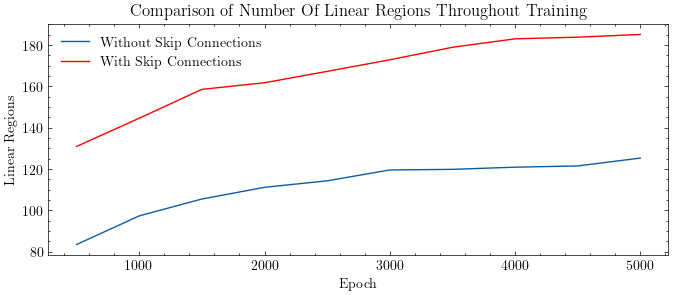

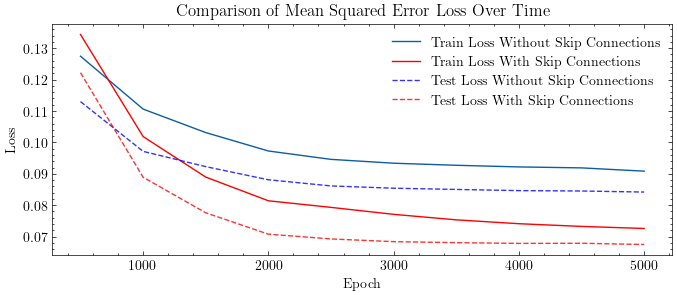

In [14]:
overall_linear_region_hist = []
overall_linear_region_hist_skip = []
overall_loss_hist = []
overall_loss_hist_skip = []
overall_testloss_hist = []
overall_testloss_hist_skip = []

for trial in range(5):
    print(trial)
    for i in tqdm(range(len(functions)), colour="gray", desc="Functions"):
        # Model initialization
        input_size = 2
        output_size = 1
        hidden_size = 4
        num_layers = 5
        model_noskip = Approximator(input_size, hidden_size, output_size, num_layers).to(device)
        model_skip = Approximator(input_size, hidden_size, output_size, num_layers, skip_connections = [(0,2),(1,3)]).to(device)
        
        epochs_per_eval = 500
        linear_region_hist, loss_hist, testloss_hist = train_and_track(model_noskip, functions[i], num_epochs=5000, epochs_per_eval=epochs_per_eval, print_progress=False)
        linear_region_hist_skip, loss_hist_skip, testloss_hist_skip = train_and_track(model_skip, functions[i], num_epochs=5000, epochs_per_eval=epochs_per_eval, print_progress=False)
        
        overall_linear_region_hist.append(linear_region_hist)
        overall_linear_region_hist_skip.append(linear_region_hist_skip)
        overall_loss_hist.append(loss_hist)
        overall_loss_hist_skip.append(loss_hist_skip)
        overall_testloss_hist.append(testloss_hist)
        overall_testloss_hist_skip.append(testloss_hist_skip)

xcoords = epochs_per_eval*np.arange(1,len(loss_hist)+1)

fig, ax = plt.subplots(figsize=(8,3))
ax.set_title("Comparison of Number Of Linear Regions Throughout Training")
ax.plot(xcoords, np.mean(overall_linear_region_hist, axis=0),label="Without Skip Connections")
ax.plot(xcoords, np.mean(overall_linear_region_hist_skip, axis=0),label="With Skip Connections", c="red")
ax.set_xlabel("Epoch")
ax.set_ylabel("Linear Regions")
ax.legend()
fig.savefig(f"images/skipvsnoskip_linearregions_{num_layers}layers_{hidden_size}neurons.svg")
plt.show()

fig, ax = plt.subplots(figsize=(8,3))
ax.set_title("Comparison of Mean Squared Error Loss Over Time")
# ax.plot(xcoords, np.mean(overall_loss_hist, axis=0),label="Without Skip Connections")
# ax.plot(xcoords, np.mean(overall_loss_hist_skip, axis=0),label="With Skip Connections", c="red")
ax.plot(xcoords, np.mean(overall_loss_hist, axis=0),label="Train Loss Without Skip Connections")
ax.plot(xcoords, np.mean(overall_loss_hist_skip, axis=0),label="Train Loss With Skip Connections", c="red")
ax.plot(xcoords, np.mean(overall_testloss_hist, axis=0),label="Test Loss Without Skip Connections", c="blue", linestyle="--", alpha=0.8)
ax.plot(xcoords, np.mean(overall_testloss_hist_skip, axis=0),label="Test Loss With Skip Connections", c="red", linestyle="--", alpha=0.8)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()
fig.savefig(f"images/skipvsnoskip_loss_{num_layers}layers_{hidden_size}neurons.svg")
plt.show()

## Classification Experiment

### Using a classifier on MNIST dataset, write using caching algorithm to see how often cached results appear

In [484]:
def train_classifier(model, train_loader, test_loader, num_epochs=10, learning_rate=5e-4):
    """
    Train a basic MNIST classifier
    """

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in tqdm(range(num_epochs), mininterval=0.5, leave=False, desc="Epochs"):
        model.train()
        running_loss = 0.0
        for (X_in, y_in) in tqdm(train_loader, leave=False, mininterval=0.5, desc=f"Epoch {epoch+1}"):
            X_in = X_in.to(device)
            y_in = y_in.to(device)
            optimizer.zero_grad()
            outputs = model(X_in)
            loss = criterion(outputs, y_in)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()
        print(f"Epoch [{epoch+1}/{num_epochs}] total loss: {running_loss:.4f}")
    
        with torch.no_grad():
            model.eval()
            test_loss = 0.0
            for (X_test, y_test) in test_loader:
                X_test = X_test.to(device)
                y_test = y_test.to(device)
                
                outputs = model(X_test)
                loss = criterion(outputs, y_test)
                test_loss += loss.item()
        print(f"Test Loss: {test_loss:.4f}")

# Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist.data, mnist.target.astype(int)

# Train-test split
kfold = KFold(n_splits=5, shuffle=False)
for i, (train_idx, test_idx) in enumerate(kfold.split(X)):
    X_train = X.loc[train_idx]
    y_train = y.loc[train_idx]
    X_test = X.loc[test_idx]
    y_test = y.loc[test_idx]
    break

batch_size = 64

# Set up data loaders
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_one_hot = torch.nn.functional.one_hot(torch.tensor(y_train.values, dtype=torch.long), num_classes=10).float()
y_test_one_hot = torch.nn.functional.one_hot(torch.tensor(y_test.values, dtype=torch.long), num_classes=10).float()
train_dataset = TensorDataset(X_train_tensor, y_train_one_hot)
test_dataset = TensorDataset(X_test_tensor, y_test_one_hot)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

### Plot Reduced-Dimension Representations

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/875 [00:00<?, ?it/s]

Epoch [1/10] total loss: 104.3552
Test Loss: 13.4209


Epoch 2:   0%|          | 0/875 [00:00<?, ?it/s]

Epoch [2/10] total loss: 42.6913
Test Loss: 9.9227


Epoch 3:   0%|          | 0/875 [00:00<?, ?it/s]

Epoch [3/10] total loss: 34.2195
Test Loss: 8.9730


Epoch 4:   0%|          | 0/875 [00:00<?, ?it/s]

Epoch [4/10] total loss: 30.2974
Test Loss: 8.3788


Epoch 5:   0%|          | 0/875 [00:00<?, ?it/s]

Epoch [5/10] total loss: 27.8194
Test Loss: 7.9679


Epoch 6:   0%|          | 0/875 [00:00<?, ?it/s]

Epoch [6/10] total loss: 25.6914
Test Loss: 7.6791


Epoch 7:   0%|          | 0/875 [00:00<?, ?it/s]

Epoch [7/10] total loss: 23.7839
Test Loss: 7.1846


Epoch 8:   0%|          | 0/875 [00:00<?, ?it/s]

Epoch [8/10] total loss: 22.4238
Test Loss: 7.6009


Epoch 9:   0%|          | 0/875 [00:00<?, ?it/s]

Epoch [9/10] total loss: 21.3851
Test Loss: 7.5159


Epoch 10:   0%|          | 0/875 [00:00<?, ?it/s]

Epoch [10/10] total loss: 20.6304
Test Loss: 7.5030


Checking linear regions of training data:   0%|          | 0/56000 [00:00<?, ?it/s]

Number of distinct linear regions in training data: 38400


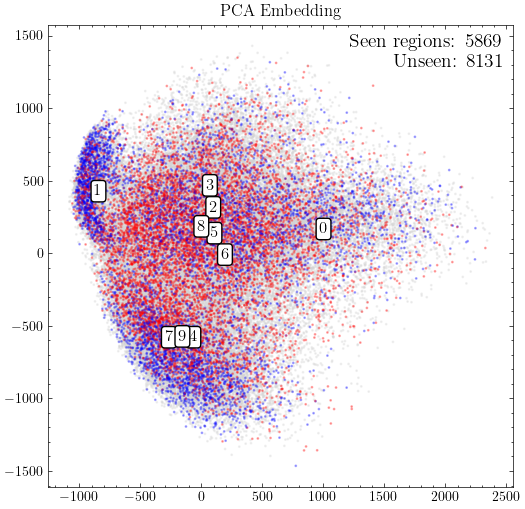

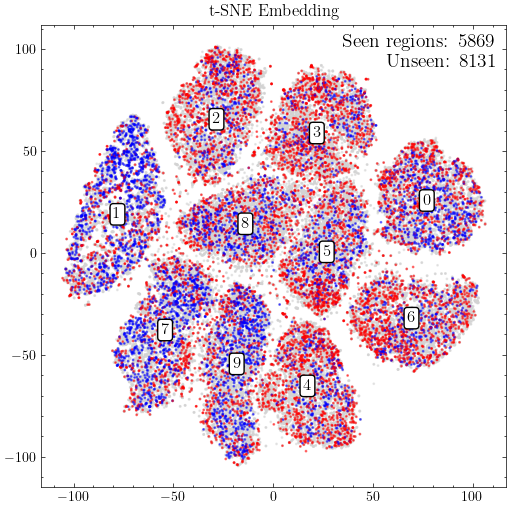

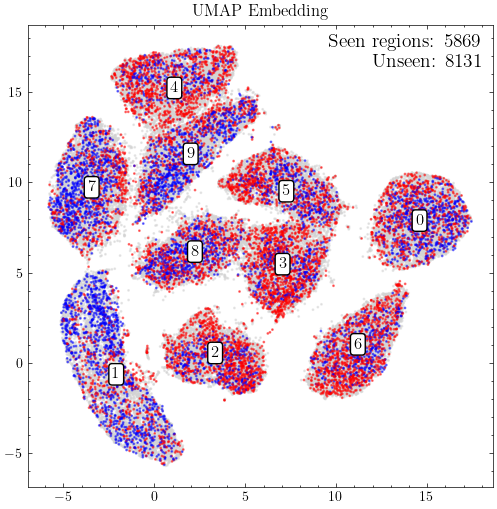

In [499]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import umap_

def mean_coordinates(X_coords, y_all):
    """
    Helper function for `plot_digit_centroids`. Finds mean coords corresponding to each digit
    """
    mean_coords = {}
    for digit in range(10):  # Digits 0-9
        digit_coords = X_coords[y_all == digit]
        mean_coord = digit_coords.mean(axis=0)
        mean_coords[digit] = mean_coord
    return mean_coords

def plot_digit_centroids(X_coords, y_all, ax=None):
    """
    Adds labels to scatter plot with name of each digit
    """
    if ax is None:
        ax = plt.gca()
    for digit, (x, y) in mean_coordinates(X_coords, y_all).items():
        ax.text(x, y, str(digit), fontsize=12, ha="center", va="center", color="black",
                bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.2"))


def region_of_datapoint(model, img):
    """
    Given a model and an input `img`, returns string of 0s and 1s representing whether each ReLU pre-activation is positive or negative
    """
    prediction = img.to("cpu")
    region = []
    layer_index = 0
    previous = [] # Skip connections
    for i in range(len(model.model)):
        layer = model.model[i]
        if isinstance(layer, nn.Linear):
            A = layer.weight.detach()#.numpy()
            b = layer.bias.detach()#.numpy()
            if model.skip_connections is not None: # Handle skips
                skips_in = [j for (j,k) in model.skip_connections if k==layer_index]
                for j in skips_in:
                    prediction += previous[j]
            prediction = A @ prediction + b
            next_layer = model.model[i+1] if i < len(model.model)-1 else None
            if isinstance(next_layer, nn.ReLU): # If layer has ReLU activation
                region.extend((prediction < 0).int().numpy())
                prediction = nn.functional.relu(prediction)
            previous.append(prediction) # Post-activation output
            layer_index += 1
    return str(np.array(region)) # Hashable representation to allow use in set()


# Model initialization
hidden_size = 16
num_layers = 4
input_size = 784
output_size = 10
skip_connections = None#[(0,2), (1,3)]
mnist_model = Approximator(input_size, hidden_size, output_size, num_layers, skip_connections).to(device)
skip_filename = "skip" if mnist_model.skip_connections is not None else "noskip"

train_classifier(mnist_model, train_loader, test_loader)

# Get all regions where at least one training set entry exists
mnist_model.to("cpu")
regions = set()
for i in tqdm(range(len(X_train_tensor)),leave=False, desc="Checking linear regions of training data"):
    img = X_train_tensor[i]
    region = region_of_datapoint(mnist_model, img)
    regions.add(region)
print(f"Number of distinct linear regions in training data: {len(regions)}")

# For each entry of test set, check whether it lies in the same linear region as an entry of train set
is_seen = [region_of_datapoint(mnist_model, img) in regions for img in X_test_tensor]
num_seen = sum(is_seen)
num_unseen = len(X_test) - num_seen
X_all = np.vstack([X_train_tensor.numpy(), X_test_tensor.numpy()])
y_all = np.hstack([y_train,y_test])
colors = ["lightgray" for _ in range(len(X_train))] + ["blue" if elem else "red" for elem in is_seen]

# PCA
if "pca" not in locals(): # Avoid re-running if not needed
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_all)
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(X_pca[:,0], X_pca[:,1], c=colors, s=1, alpha=0.3, rasterized=True)
ax.set_title("PCA Embedding")
plot_digit_centroids(X_pca, y_all)
ax.text(.98, .98, f"Seen regions: {num_seen}\nUnseen: {num_unseen}", ha="right", va="top", fontsize=14, transform=ax.transAxes)
fig.savefig(f"images/embeddings/embed-pca-{skip_filename}-{num_layers}layers-{hidden_size}neurons.svg")
plt.show()

# t-SNE
if "tsne" not in locals(): # Avoid re-running if not needed
    tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=0)
    X_tsne = tsne.fit_transform(X_all)
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=colors, s=1, alpha=0.5, rasterized=True)
plot_digit_centroids(X_tsne, y_all)
ax.set_title("t-SNE Embedding")
ax.text(.98, .98, f"Seen regions: {num_seen}\nUnseen: {num_unseen}", ha="right", va="top", fontsize=14, transform=ax.transAxes)
fig.savefig(f"images/embeddings/embed-tsne-{skip_filename}-{num_layers}layers-{hidden_size}neurons.svg")
plt.show()

# UMAP
if "umap" not in locals(): # Avoid re-running if not needed
    umap = umap_.UMAP(n_neighbors=5, min_dist=0.3, random_state=0)
    X_umap = umap.fit_transform(X_all)
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(X_umap[:, 0], X_umap[:, 1], c=colors, s=1, alpha=0.5, rasterized=True)
ax.set_title("UMAP Embedding")
plot_digit_centroids(X_umap, y_all)
ax.text(.98, .98, f"Seen regions: {num_seen}\nUnseen: {num_unseen}", ha="right", va="top", fontsize=14, transform=ax.transAxes)
fig.savefig(f"images/embeddings/embed-umap-{skip_filename}-{num_layers}layers-{hidden_size}neurons.svg")
plt.show()

## Additional/miscellaneous tools

### Sample points from a single linear region

Select a random starting point. Determine the linear region it belongs to by checking which side of each hyperplane it lies on.

Use linear programming to find the smallest bounding box that contains the linear region. Sample from the bounding box, discarding any points that lie outside of the region.

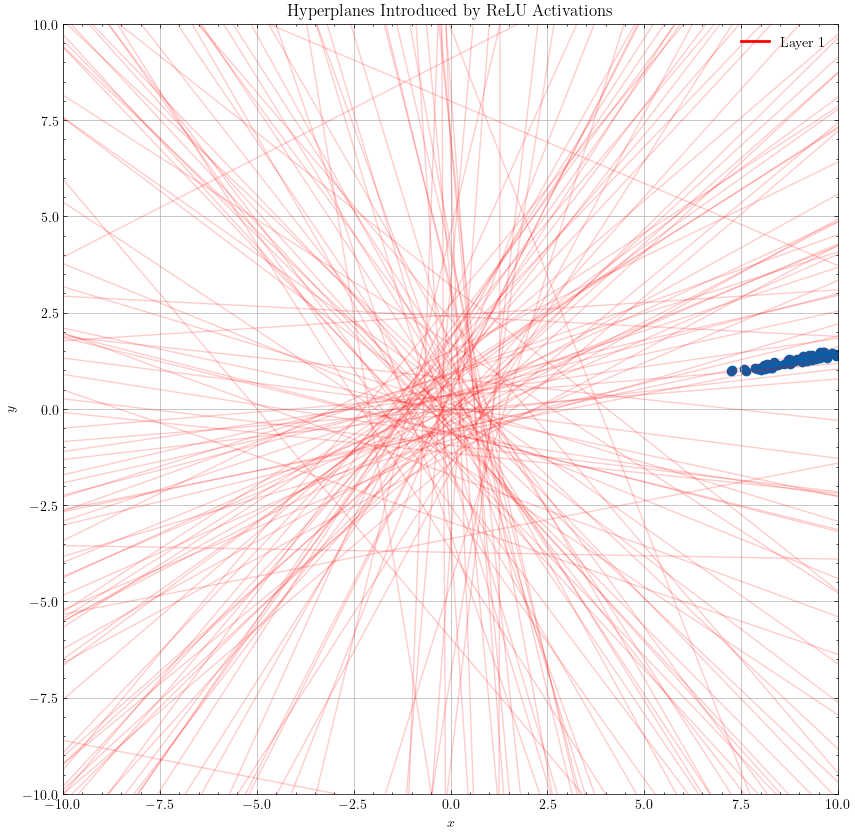

In [47]:
def find_bounding_box(A, b, box_min=None, box_max=None):
    """
    Helper function for `sample_from_bounding_box`.
    Find a 2d bounding box for a given linear region defined by constraints Ax<=b.
    """
    bounds=[]
    
    for i in range(len(A[0])): # For each input dimension
        # Minimize x_i
        c = np.zeros(len(A[0]))
        c[i] = 1
        res_min = linprog(c, A_ub=A, b_ub=b, bounds=(None, None), method='highs')
        min_val = res_min.x[i] if res_min.success else initial_point[i]
        if res_min.status == 3:  # Unbounded
            min_val = box_min[i] if box_min is not None else -np.inf

        # Maximize x_i
        c = np.zeros(len(A[0]))
        c[i] = -1
        res_max = linprog(c, A_ub=A, b_ub=b, bounds=(None, None), method='highs')
        max_val = res_max.x[i] if res_max.success else initial_point[i]
        if res_max.status == 3:  # Unbounded
            max_val = box_max[i] if box_max is not None else np.inf

        bounds.append((min_val, max_val))

    return bounds

def sample_from_bounding_box(A, b, bounds, num_samples):
    """
    Samples from linear region defined by Ax<=b. 
    Finds a bounding box, then generates samples from the bounding box, discarding any samples outside of linear region.
    """
    samples = []
    for _ in range(num_samples):
        point = np.array([np.random.uniform(low, high) for low, high in bounds])
        if np.all(np.dot(A, point) <= b):
            samples.append(point)
    return np.array(samples)
    
x_range=(-10, 10)
y_range=(-10, 10)
initial_point = np.random.uniform([x_range[0], y_range[0]], [x_range[1], y_range[1]])
num_samples = 500

# Determine which side of each hyperplane the initial point is on
sides = np.array([1 if np.dot(weights, initial_point) + bias <= 0 else -1 for weights, bias, _ in hyperplanes])

# Define the region as a set of linear inequalities
A = []
b = []
for (weights, bias, _), side in zip(hyperplanes, sides):
    A.append(weights * side)
    b.append(-bias * side)


bounds = find_bounding_box(A, b, box_min = [-10, -10], box_max = [10, 10])
samples = sample_from_bounding_box(A, b, bounds, num_samples)

plot_hyperplanes(hyperplanes, num_layers, points=samples,alpha=0.2)

### Verify that neural network outputs are coplanar on linear region

In [46]:
def check_coplanarity(points, tolerance=1e-3):
    """
    Use the scalar triple product of first three points to check coplanarity
    """
    p0 = points[0]
    for i in range(1, len(points) - 2):
        p1 = points[i]
        p2 = points[i + 1]
        p3 = points[i + 2]
        v1 = p1 - p0
        v2 = p2 - p0
        v3 = p3 - p0
        volume = np.dot(v1, np.cross(v2, v3))
        if abs(volume) > tolerance:
            return False
    return True

# Convert sampled points to PyTorch tensor
inputs = torch.tensor(samples, dtype=torch.float32)
model.eval()
with torch.no_grad():
    outputs = model(inputs).numpy()

# Check coplanarity of the output points
output_points = np.hstack([samples, outputs])
is_coplanar = check_coplanarity(output_points)

print(f"Model outputs {'ARE' if is_coplanar else 'ARE NOT'} coplanar")

Model outputs ARE coplanar


### Plot linear region outputs in 3D, and view from angle showing coplanarity

In [ ]:
def get_normal_vector(points):
    # Use the first three points to define the plane
    p0, p1, p2 = points[:3]
    v1 = p1 - p0
    v2 = p2 - p0
    normal_vector = np.cross(v1, v2)
    return normal_vector

def plot_points_with_view(points, title="Output Points"):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Extract x, y, and z coordinates
    x = points[:, 0]
    y = points[:, 1]
    z = points[:, 2]
    
    # Plot the points
    ax.scatter(x, y, z, c='b', marker='o', alpha=0.5)
    
    # Find the normal vector of the plane
    normal_vector = get_normal_vector(points)

    # Plot the normal vector
    origin = np.mean(points, axis=0)
    ax.quiver(origin[0], origin[1], origin[2], normal_vector[0], normal_vector[1], normal_vector[2], 
              length=5.0, color='r', arrow_length_ratio=0.1)
    
    # # Use the first two points to define a vector on the plane
    p0, p1 = points[:2]
    plane_vector = p1 - p0
    
    # Set azimuth and elevation angles
    azimuth = np.degrees(np.arctan2(plane_vector[1], plane_vector[0]))
    elevation = np.degrees(np.arctan2(plane_vector[2], np.sqrt(plane_vector[0]**2 + plane_vector[1]**2)))
    print(f"Azimuth: {azimuth}, Elevation: {elevation}")
    # if elevation < 0: # If elevation is negative, view from opposite side
    #     elevation *= -1
    #     azimuth += 180
    ax.view_init(elev=elevation, azim=azimuth)
    
    # Set labels
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.set_zlabel("$z$")
    ax.set_title(title)
    
    plt.show()

plot_points_with_view(output_points, title="Network Output on a Single Linear Region")

In [ ]:
removed_hyperplane_idx = 0
remaining_hyperplanes = hyperplanes.copy()
removed_hyperplane = remaining_hyperplanes.pop(removed_hyperplane_idx)
removed_hyperplane

initial_x = np.random.random

# Convert sampled points to PyTorch tensor
inputs = torch.tensor(samples, dtype=torch.float32)
model.eval()
with torch.no_grad():
    outputs = model(inputs).numpy()

# Check coplanarity of the output points
output_points = np.hstack([samples, outputs])
is_coplanar = check_coplanarity(output_points)

print(f"Model outputs {'ARE' if is_coplanar else 'ARE NOT'} coplanar")